In [1]:
# Install required packages
%pip install -e .

Obtaining file:///C:/Users/yecha/workspace/JPMSummer
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for jpm-project (pyproject.toml): started
  Building editable for jpm-project (pyproject.toml): finished with status 'done'
  Created wheel for jpm-project: filename=jpm_project-0.1.0-0.editable-py3-none-any.whl size=4475 sha256=0c875419152f7eb786ba079d75085fd3ef379a01c3fa0b9890617d81cfff485f
  Stored in directory: C:\Users\yecha\AppData\Local\Temp\pip-ephem-wheel-cache-je7ifusa\wheels\be\5f\86\24627408396487f9c11bfb0ef9081f03e

# Kalman Filter Demonstrations

This notebook demonstrates both the Linear Kalman Filter and Extended Kalman Filter implementations
from the `jpm-project` package. We'll show:

1. Linear KF on a simple constant + noise model
2. Extended KF on a nonlinear growth model
3. Visualization of results and comparison

In [2]:
# Setup imports and path so `src` package is importable
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import logging
# Reduce TensorFlow logging to suppress known deprecation warnings from TF and TFP
# Set C++ minimal log level (0=all,1=INFO,2=WARNING,3=ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Reduce Python-side TensorFlow logger verbosity
try:
    tf.get_logger().setLevel(logging.ERROR)
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    # Also set v1 logging verbosity if available
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception:
    pass

# ensure the project root is on sys.path so `src` is importable
# project_root = r"C:\Users\yecha\workspace\JPMSummer"
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

from src.data.data import SSMData, StochasticVariationalData
from src.models.KalmanFilter import KalmanFilter
from src.models.ExtendedKalmanFilter import ExtendedKalmanFilter
from src.models.UnscentedKalmanFilter import UnscentedKalmanFilter
from src.models.ParticleFilter import ParticleFilter

import tensorflow_probability as tfp
tfd = tfp.distributions

tf.random.set_seed(1)
np.random.seed(1)

## 1. Linear Kalman Filter Example

First, we'll demonstrate the linear Kalman filter on a simple constant + noise model:

$x_t = x_{t-1} + q_t$  (state stays constant with noise)
$y_t = x_t + r_t$      (observe state with noise)

where $q_t \sim N(0, 0.1)$ and $r_t \sim N(0, 0.5)$ are process and observation noise.

In [3]:
# Generate synthetic multivariate data (random system matrices)
T = 100  # number of time steps
# state dimension (d) and observation dimension (d-1)
d = 4  # change this to try other dimensions
obs_dim = d

# RNG for reproducibility
rng = np.random.default_rng(42)

# Random transition matrix A (d x d). Scale to avoid explosive dynamics.
F = np.array([[1, 0, 1, 0],
              [0, 1, 0, 1],
              [0, 0, -1, 0],
              [0, 0, 0, -1]])

# Random observation matrix H (obs_dim x d)
H = rng.normal(size=(obs_dim, d))

# Process and observation covariances (diagonal for simplicity)
Q = np.eye(d) * 0.3
R = np.eye(obs_dim) * 0.5

# Simulate states and observations
states = np.zeros((T + 1, d))
observations = np.zeros((T, obs_dim))
for t in range(T):
    states[t+1] = F @ states[t] + rng.normal(scale=np.sqrt(0.1), size=(d,))
    observations[t] = H @ states[t+1] + rng.normal(scale=np.sqrt(0.5), size=(obs_dim,))

# Create and run Kalman filter (convert to numpy arrays as before)
kf = KalmanFilter(
    transition_matrix=np.array(F),
    observation_matrix=np.array(H),
    transition_cov=np.array(Q),
    observation_cov=np.array(R),
    initial_mean=np.zeros((d,)),
    initial_cov=np.eye(d),
)

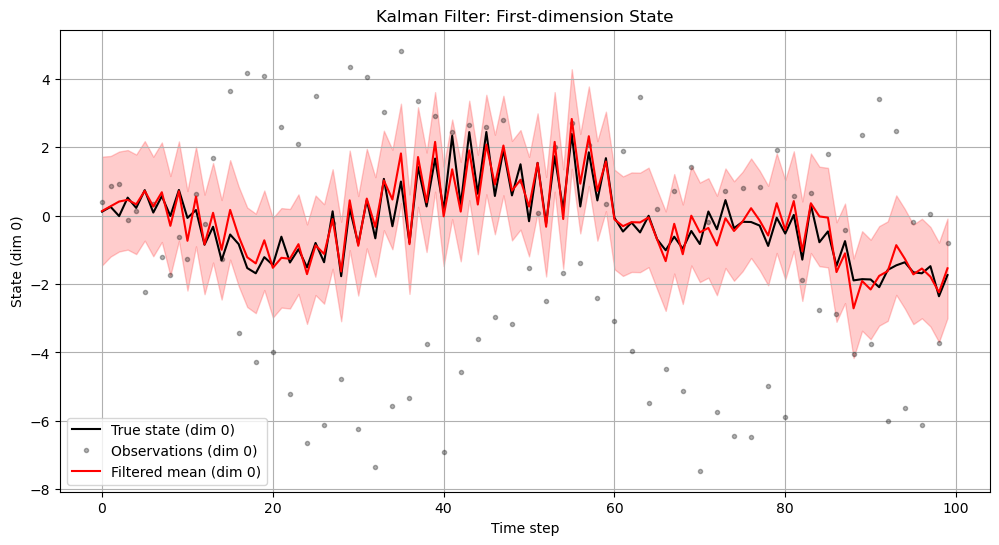

<Figure size 640x480 with 0 Axes>

Log-likelihood: -645.05


In [ ]:
# Run filter and get results
filtered_means, filtered_covs, loglik = kf.filter(observations)

# Plot results (showing first state / first observation dimension)
plt.figure(figsize=(12, 6))
t = np.arange(T)
# plot first state dimension
plt.plot(t, states[1:, 0], 'k-', label='True state (dim 0)')
# plot first observation dimension (if obs_dim==1 this is fine)
plt.plot(t, observations[:, 0], 'k.', alpha=0.3, label='Observations (dim 0)')
plt.plot(t, filtered_means.numpy()[:, 0], 'r-', label='Filtered mean (dim 0)')

# Add uncertainty bands (2 standard deviations) for state-dim 0
std = np.sqrt(np.array([cov[0,0] for cov in filtered_covs.numpy()]))
plt.fill_between(t, 
                filtered_means.numpy()[:, 0] - 2*std,
                filtered_means.numpy()[:, 0] + 2*std,
                color='r', alpha=0.2)

plt.xlabel('Time step')
plt.ylabel('State (dim 0)')
plt.title('Kalman Filter: First-dimension State')
plt.legend()
plt.grid(True)
plt.show()

# Ensure output folder exists and save figure
# import os
# os.makedirs('figures', exist_ok=True)
plt.savefig(os.path.join('figures', 'kalman_kf_dim0.pdf'), bbox_inches='tight')
plt.show()

print(f"Log-likelihood: {float(loglik):.2f}")

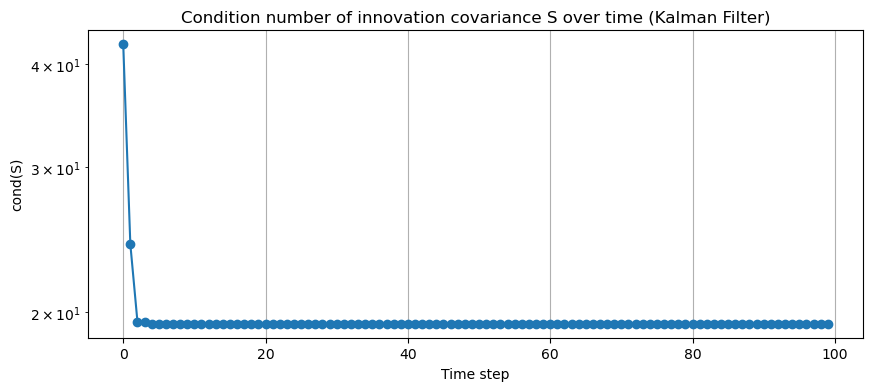

cond(S) - min: 1.938e+01, mean: 1.966e+01, max: 4.235e+01


In [ ]:
# Plot conditioning number (cond(S)) from Kalman filter
import numpy as np
import matplotlib.pyplot as plt

# `kf.cond_history` is populated by `KalmanFilter.filter()`
cond = np.array(kf.cond_history)
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(cond)), cond, marker='o')
plt.yscale('log')
plt.xlabel('Time step')
plt.ylabel('cond(S)')
plt.title('Condition number of innovation covariance S over time (Kalman Filter)')
plt.grid(True)
# Ensure figures folder exists and save conditioning plot
# import os
# os.makedirs('figures', exist_ok=True)
plt.savefig(os.path.join('figures', 'kalman_cond_S.pdf'), bbox_inches='tight')
plt.show()

print(f"cond(S) - min: {np.nanmin(cond):.3e}, mean: {np.nanmean(cond):.3e}, max: {np.nanmax(cond):.3e}")

## 2) Generate stochastic variational dataset

We use the `StochasticVariationalData` class (1D) added to `data.py`.
Model (1D):
- X_k = alpha * X_{k-1} + sigma * eta_k  (eta_k ~ N(0,1))
- Y_k = beta * exp(X_k / 2) * epsilon_k (epsilon_k ~ N(0,1))

We'll simulate a series and visualize the latent log-volatility X and observations Y.

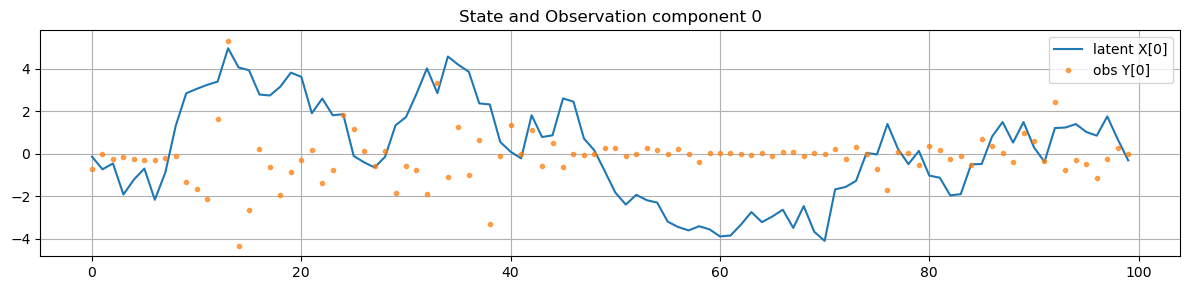

In [ ]:
# Parameters for stochastic variational (stochastic volatility-like) model
alpha = 0.91
sigma = 1
beta = 0.5
T_sv = 100
n_state = 1
n_obs = 1
num_particles = 1000
seed = 42

sv = StochasticVariationalData(alpha=alpha, 
                               sigma=sigma, 
                               beta=beta, 
                               n_state=n_state,
                               n_obs=n_obs,
                            #    initial_state=0.0, 
                               dtype=tf.float64)
x_sv_tf, y_sv_tf = sv.sample(num_steps=T_sv, seed=seed)
# x_sv: shape (T+1, n_state), y_sv: shape (T, n_obs)
x_sv = x_sv_tf.numpy()  # shape (T+1, n_state)
y_sv = y_sv_tf.numpy()  # shape (T, n_obs)

# Plot latent state components and observations together (one subplot per index)

os.makedirs('figures', exist_ok=True)
n_plots = max(1, max(n_state, n_obs))
plt.figure(figsize=(12, 3 * n_plots))
for i in range(n_plots):
    plt.subplot(n_plots, 1, i + 1)
    if i < n_state:
        plt.plot(x_sv[1:, i], '-', label=f'latent X[{i}]')
    if i < n_obs:
        plt.plot(y_sv[:, i], '.', alpha=0.7, label=f'obs Y[{i}]')
    plt.title(f'State and Observation component {i}')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
# Save combined figure
plt.savefig(os.path.join('figures', 'sv_states_and_obs.pdf'), bbox_inches='tight')
plt.show()

In [ ]:

def f(x: tf.Tensor) -> tf.Tensor:
    # Support scalar or per-dimension `alpha` and both vector/batch inputs
    x = tf.cast(x, dtype=tf.float64)
    a = tf.cast(alpha, dtype=tf.float64)
    return a * x


def h(x: tf.Tensor) -> tf.Tensor:
    # Elementwise volatility transform: beta * exp(x/2).
    # Accepts vector (n_state,) or batch (N, n_state). If an observation
    # matrix `C` is present in the notebook namespace, map the per-state
    # contributions into observation space: y = C @ z.
    x = tf.cast(x, dtype=tf.float64)
    b = tf.cast(beta, dtype=tf.float64)
    z = b * tf.exp(x / 2.0)
    return z

# Approximate observation covariance R and process covariance Q for multivariate state
# Ensure beta and sigma are vectors of length n_state for per-dimension scaling
beta_vec = np.asarray(beta) if np.ndim(beta) > 0 else np.full((n_state,), float(beta))
sigma_vec = np.asarray(sigma) if np.ndim(sigma) > 0 else np.full((n_state,), float(sigma))
# x_sv has shape (T+1, n_state); use time indices 1..T to compute empirical mean
# emp_R_diag = (beta_vec ** 2) * np.mean(np.exp(x_sv[1:, :]), axis=0)
# R_approx = np.diag(emp_R_diag).astype(float)
Q_approx = np.eye(n_state) * (sigma_vec ** 2)

# Initial conditions
initial_mean = np.zeros((n_state,))
initial_cov = np.eye(n_state)

R_approx = 1.0 * np.eye(n_state)
# Q_approx = 0.5 * np.eye(n_state)
print("Approximate R:", R_approx)
print("Approximate Q:", Q_approx)
print("initial_mean:", initial_mean)
print("initial_cov:", initial_cov)
num_particles = 1000

Approximate R: [[0.5]]
Approximate Q: [[0.5]]
initial_mean: [0.]
initial_cov: [[1.]]


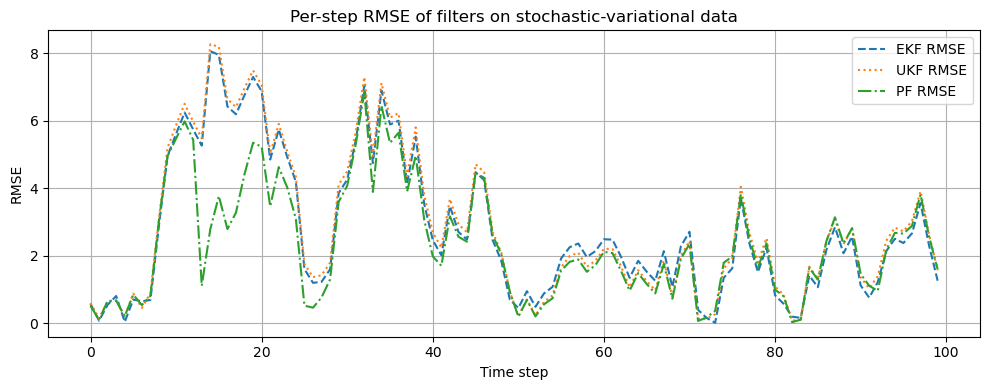

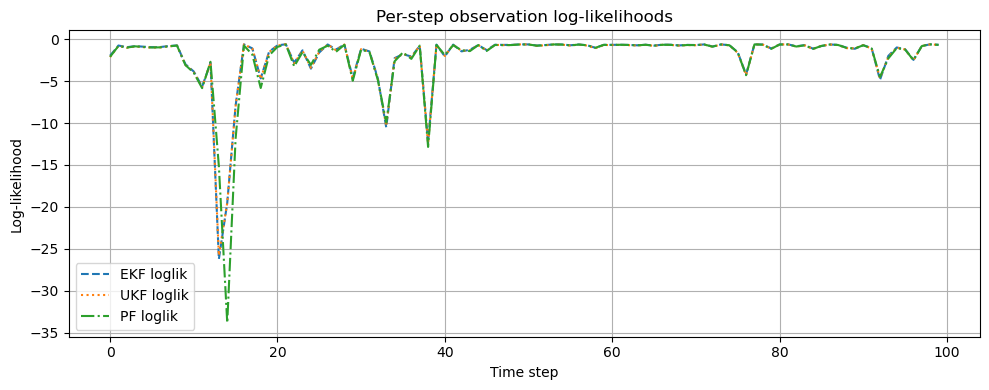

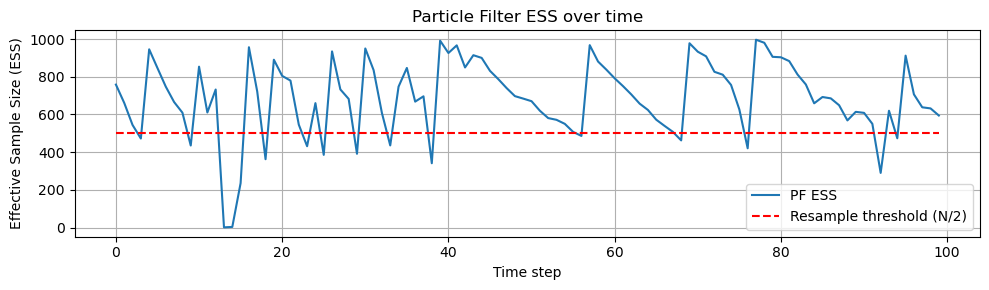

Summary (stochastic-variational filters):
  EKF - avg RMSE: 2.7624, avg per-step loglik: -1.9866
  UKF - avg RMSE: 2.8676, avg per-step loglik: -2.0068
  PF  - avg RMSE: 2.3523, avg per-step loglik: -2.1136, avg ESS: 685.212
  PF  - min ESS: 1.046, fraction ESS < N/2: 16.00%


In [8]:
verbose = True
# Create EKF and UKF instances
sv_ekf = ExtendedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)

sv_ukf = UnscentedKalmanFilter(
    f=f,
    h=h,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov, dtype=tf.float64),
)

# PF for stochastic volatility
sv_pf = ParticleFilter(
    transition_fn=f,
    observation_fn=h,  # Original observation function for PF
    Q=Q_approx,
    R=R_approx,  # Original observation noise for PF
    num_particles=num_particles,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    seed=42,
)

# Prepare observations and true states for evaluation
obs = tf.convert_to_tensor(y_sv.reshape(-1, 1), dtype=tf.float64)
# true latent states for RMSE (drop initial state at t=0)
true_states = x_sv[1:]  # shape (T, n_state)

# Run filters and pass true states so they populate rmse/ll histories
pf_means_tf, pf_covs_tf, pf_ll = sv_pf.filter(obs, true_states=true_states)
ekf_means_tf, ekf_covs_tf, ekf_ll = sv_ekf.filter(obs, true_states=true_states)
ukf_means_tf, ukf_covs_tf, ukf_ll = sv_ukf.filter(obs, true_states=true_states)

# Collect per-step histories (convert to NumPy arrays for plotting)
ekf_rmse = np.array(sv_ekf.rmse_history)
ekf_ll_hist = np.array(sv_ekf.ll_history)
ukf_rmse = np.array(sv_ukf.rmse_history)
ukf_ll_hist = np.array(sv_ukf.ll_history)
pf_rmse = np.array(sv_pf.rmse_history)
pf_ll_hist = np.array(sv_pf.ll_history)
pf_ess = np.array(sv_pf.ess_history)

# Ensure figures directory exists
import os
os.makedirs('figures', exist_ok=True)

# Plot RMSE over time
plt.figure(figsize=(10, 4))
t = np.arange(len(true_states))
if ekf_rmse.size > 0:
    plt.plot(t, ekf_rmse, '--', label='EKF RMSE')
if ukf_rmse.size > 0:
    plt.plot(t, ukf_rmse, ':', label='UKF RMSE')
if pf_rmse.size > 0:
    plt.plot(t, pf_rmse, '-.', label='PF RMSE')
plt.xlabel('Time step')
plt.ylabel('RMSE')
plt.title('Per-step RMSE of filters on stochastic-variational data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join('figures', 'filters_rmse.pdf'), bbox_inches='tight')
plt.show()

# Plot per-step log-likelihood (observation log-probabilities)
plt.figure(figsize=(10, 4))
if ekf_ll_hist.size > 0:
    plt.plot(t, ekf_ll_hist, '--', label='EKF loglik')
if ukf_ll_hist.size > 0:
    plt.plot(t, ukf_ll_hist, ':', label='UKF loglik')
if pf_ll_hist.size > 0:
    plt.plot(t, pf_ll_hist, '-.', label='PF loglik')
plt.xlabel('Time step')
plt.ylabel('Log-likelihood')
plt.title('Per-step observation log-likelihoods')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join('figures', 'filters_loglik.pdf'), bbox_inches='tight')
plt.show()

# Plot ESS for particle filter
plt.figure(figsize=(10, 3))
if pf_ess.size > 0:
    plt.plot(t, pf_ess, label='PF ESS')
    plt.hlines(sv_pf.num_particles / 2.0, 0, len(t)-1, colors='r', linestyles='--', label='Resample threshold (N/2)')
plt.xlabel('Time step')
plt.ylabel('Effective Sample Size (ESS)')
plt.title('Particle Filter ESS over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join('figures', 'pf_ess.pdf'), bbox_inches='tight')
plt.show()

# Print summary statistics: average RMSE, average per-step log-likelihood, and ESS summary
import math
def safe_mean(arr):
    try:
        return float(np.nanmean(arr))
    except Exception:
        return float('nan')

ekf_avg_rmse = safe_mean(ekf_rmse) if ekf_rmse.size > 0 else float('nan')
ukf_avg_rmse = safe_mean(ukf_rmse) if ukf_rmse.size > 0 else float('nan')
pf_avg_rmse  = safe_mean(pf_rmse)  if pf_rmse.size > 0 else float('nan')

ekf_avg_loglik = safe_mean(ekf_ll_hist) if ekf_ll_hist.size > 0 else float('nan')
ukf_avg_loglik = safe_mean(ukf_ll_hist) if ukf_ll_hist.size > 0 else float('nan')
pf_avg_loglik  = safe_mean(pf_ll_hist)  if pf_ll_hist.size > 0 else float('nan')

pf_avg_ess = safe_mean(pf_ess) if pf_ess.size > 0 else float('nan')
pf_min_ess = float(np.nanmin(pf_ess)) if pf_ess.size > 0 else float('nan')
pf_resample_frac = float(np.mean(pf_ess < (sv_pf.num_particles / 2.0))) if pf_ess.size > 0 else float('nan')

print('Summary (stochastic-variational filters):')
print(f'  EKF - avg RMSE: {ekf_avg_rmse:.5g}, avg per-step loglik: {ekf_avg_loglik:.5g}')
print(f'  UKF - avg RMSE: {ukf_avg_rmse:.5g}, avg per-step loglik: {ukf_avg_loglik:.5g}')
print(f'  PF  - avg RMSE: {pf_avg_rmse:.5g}, avg per-step loglik: {pf_avg_loglik:.5g}, avg ESS: {pf_avg_ess:.3f}')
print(f'  PF  - min ESS: {pf_min_ess:.3f}, fraction ESS < N/2: {pf_resample_frac:.2%}')


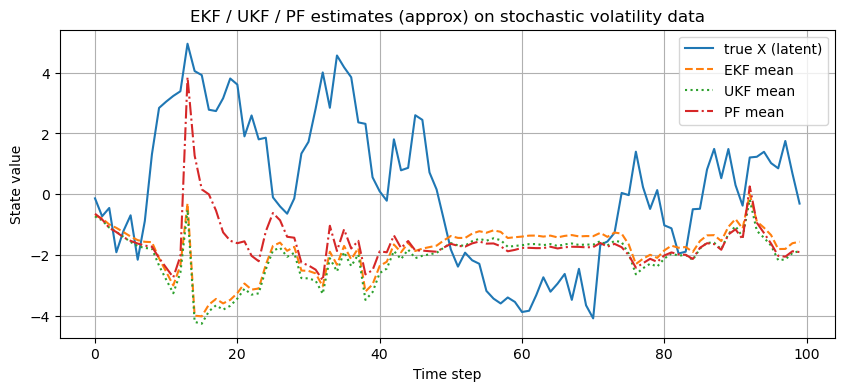

In [13]:
sv_ekf_means = ekf_means_tf.numpy().squeeze()
sv_ukf_means = ukf_means_tf.numpy().squeeze()
sv_pf_means = pf_means_tf.numpy().squeeze() 

plt.figure(figsize=(10, 4))
plt.plot(x_sv[1:], label='true X (latent)')
# plt.plot(y_sv[1:], label='Y (observed)')
plt.plot(sv_ekf_means, '--', label='EKF mean')
plt.plot(sv_ukf_means, ':', label='UKF mean')
plt.plot(sv_pf_means, '-.', label='PF mean')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.legend()
plt.grid(True)
plt.title('EKF / UKF / PF estimates (approx) on stochastic volatility data')
# Ensure figures directory exists and save the figure
import os
os.makedirs('figures', exist_ok=True)
plt.savefig(os.path.join('figures', 'sv_filters_estimates.pdf'), bbox_inches='tight')
plt.show()

In [10]:
# Plot EDH/LEDH flow diagnostics
import os
import numpy as np
import matplotlib.pyplot as plt
os.makedirs('figures', exist_ok=True)

def _to_np_list(lst):
    try:
        return np.array([float(x.numpy()) for x in lst])
    except Exception:
        return np.array([float(x) for x in lst])

# EDH diagnostics (global)
try:
    edh_A = _to_np_list(sv_edh.flow_A_norm_history)
    edh_b = _to_np_list(sv_edh.flow_b_norm_history)
    edh_disp = _to_np_list(sv_edh.flow_disp_norm_history)
    edh_jac = _to_np_list(sv_edh.jacobian_cond_history)
    if edh_A.size > 0:
        plt.figure(); plt.plot(edh_A, marker='o'); plt.title('EDH: A norm per lambda step'); plt.grid(True); plt.savefig('figures/edh_A_norm.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.plot(edh_b, marker='o'); plt.title('EDH: b norm per lambda step'); plt.grid(True); plt.savefig('figures/edh_b_norm.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.plot(edh_disp, marker='o'); plt.title('EDH: avg particle displacement per lambda step'); plt.grid(True); plt.savefig('figures/edh_disp.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.semilogy(edh_jac, marker='o'); plt.title('EDH: Jacobian condition per lambda step'); plt.grid(True); plt.savefig('figures/edh_jac_cond.pdf', bbox_inches='tight'); plt.show()
except NameError:
    print('sv_edh not found; skipping EDH diagnostics')

# LEDH (local) diagnostics
try:
    ledh_A = _to_np_list(sv_ledh.flow_A_norm_history)
    ledh_disp = _to_np_list(sv_ledh.flow_disp_norm_history)
    ledh_jac = _to_np_list(sv_ledh.jacobian_cond_history)
    if ledh_A.size > 0:
        plt.figure(); plt.plot(ledh_A, marker='o'); plt.title('LEDH: avg A norm per lambda step'); plt.grid(True); plt.savefig('figures/ledh_A_norm.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.plot(ledh_disp, marker='o'); plt.title('LEDH: avg particle displacement per lambda step'); plt.grid(True); plt.savefig('figures/ledh_disp.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.semilogy(ledh_jac, marker='o'); plt.title('LEDH: jacobian condition per lambda step'); plt.grid(True); plt.savefig('figures/ledh_jac_cond.pdf', bbox_inches='tight'); plt.show()
except NameError:
    print('sv_ledh not found; skipping LEDH diagnostics')


sv_edh not found; skipping EDH diagnostics
sv_ledh not found; skipping LEDH diagnostics


In [11]:
# Plot KernelFlow diagnostics (scalar and matrix variants)
import numpy as np
import matplotlib.pyplot as plt

try:
    ks_disp = np.array([float(x) for x in ks.flow_disp_norm_history])
    ks_jac = np.array([float(x) for x in ks.jacobian_cond_history])
    if ks_disp.size > 0:
        plt.figure(); plt.plot(ks_disp, marker='o'); plt.title('KernelScalarFlow: avg displacement per step'); plt.grid(True); plt.savefig('figures/ks_disp.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.semilogy(ks_jac, marker='o'); plt.title('KernelScalarFlow: proxy Jacobian condition per step'); plt.grid(True); plt.savefig('figures/ks_jac_cond.pdf', bbox_inches='tight'); plt.show()
except NameError:
    print('ks not found; skipping KernelScalarFlow diagnostics')

try:
    km_disp = np.array([float(x) for x in km.flow_disp_norm_history])
    km_jac = np.array([float(x) for x in km.jacobian_cond_history])
    if km_disp.size > 0:
        plt.figure(); plt.plot(km_disp, marker='o'); plt.title('KernelMatrixFlow: avg displacement per step'); plt.grid(True); plt.savefig('figures/km_disp.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.semilogy(km_jac, marker='o'); plt.title('KernelMatrixFlow: proxy Jacobian condition per step'); plt.grid(True); plt.savefig('figures/km_jac_cond.pdf', bbox_inches='tight'); plt.show()
except NameError:
    print('km not found; skipping KernelMatrixFlow diagnostics')


ks not found; skipping KernelScalarFlow diagnostics
km not found; skipping KernelMatrixFlow diagnostics


In [12]:
# Plot Particle-Flow PF diagnostics (EDH_ParticleFlowPF / LEDH_ParticleFlowPF)
import numpy as np
import matplotlib.pyplot as plt

try:
    edhpf_A = np.array([float(x) for x in pf_edh.flow_A_norm_history])
    edhpf_disp = np.array([float(x) for x in pf_edh.flow_disp_norm_history])
    edhpf_jac = np.array([float(x) for x in pf_edh.jacobian_cond_history])
    if edhpf_A.size > 0:
        plt.figure(); plt.plot(edhpf_A, marker='o'); plt.title('EDH_PF: avg A norm per lambda step (aggregated)'); plt.grid(True); plt.savefig('figures/edh_pf_A_norm.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.plot(edhpf_disp, marker='o'); plt.title('EDH_PF: avg displacement per lambda step (aggregated)'); plt.grid(True); plt.savefig('figures/edh_pf_disp.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.semilogy(edhpf_jac, marker='o'); plt.title('EDH_PF: jacobian condition per lambda step (aggregated)'); plt.grid(True); plt.savefig('figures/edh_pf_jac_cond.pdf', bbox_inches='tight'); plt.show()
except NameError:
    print('pf_edh not found; skipping EDH_ParticleFlowPF diagnostics')

try:
    ledhpf_A = np.array([float(x) for x in pf_ledh.flow_A_norm_history])
    ledhpf_disp = np.array([float(x) for x in pf_ledh.flow_disp_norm_history])
    ledhpf_jac = np.array([float(x) for x in pf_ledh.jacobian_cond_history])
    if ledhpf_A.size > 0:
        plt.figure(); plt.plot(ledhpf_A, marker='o'); plt.title('LEDH_PF: avg A norm per lambda step (aggregated)'); plt.grid(True); plt.savefig('figures/ledh_pf_A_norm.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.plot(ledhpf_disp, marker='o'); plt.title('LEDH_PF: avg displacement per lambda step (aggregated)'); plt.grid(True); plt.savefig('figures/ledh_pf_disp.pdf', bbox_inches='tight'); plt.show()
        plt.figure(); plt.semilogy(ledhpf_jac, marker='o'); plt.title('LEDH_PF: jacobian condition per lambda step (aggregated)'); plt.grid(True); plt.savefig('figures/ledh_pf_jac_cond.pdf', bbox_inches='tight'); plt.show()
except NameError:
    print('pf_ledh not found; skipping LEDH_ParticleFlowPF diagnostics')


pf_edh not found; skipping EDH_ParticleFlowPF diagnostics
pf_ledh not found; skipping LEDH_ParticleFlowPF diagnostics
